In [1]:
# synthetic exps for estimating the means and the covariances for the Log-Normal distribution
#import numpy as np
#from numpy.random import uniform, normal, multivariate_normal
#from pymanopt.manifolds import Product, Euclidean, SymmetricPositiveDefinite
import pandas as pd
from timeit import default_timer as timer
from scipy.stats import invwishart
import multiprocessing
from joblib import Parallel, delayed
import pickle
from plotnine import *
from plotnine.data import mpg
import scipy.linalg as sla
import sys
sys.path.insert(1, '../')
from SPD_SURE_pytorch import *

In [2]:
def exp_lognormal(n, p, lam, mu, nu, Psi, ran_seed=0, verbose = False):
    N = mu.shape[0]
    q = Psi.shape[0]
    I = np.eye(N)
    Iq = np.eye(q)

    res = {'risk_M': pd.Series([0, 0, 0, 0], 
                index = ['FM_logE', 'FM_GL', 'SURE', 'SURE_full']),
           'risk_Sig': pd.Series([0, 0, 0, 0], 
                index = ['FM_logE', 'FM_GL', 'SURE', 'SURE_full']),
            't': pd.Series([0, 0, 0, 0], 
                index = ['FM_logE', 'FM_GL', 'SURE', 'SURE_full'])} 
    res = pd.DataFrame(res)

    np.random.seed(ran_seed)
    Sigma = invwishart.rvs(nu, Psi, size = p)
    M = np.zeros((p, N, N))
    M = np.array([SPD_normal(1, mu, Sigma[i]/lam) for i in range(p)])
    X = np.array([SPD_normal(n, M[i], Sigma[i]) for i in range(p)])

    ## log-Euclideam mean
    start = timer()
    M_logE = np.array([FM_logE(X[i]) for i in range(p)])
    end = timer()
    t_logE = end - start
    
    S_logE = (n-1)*np.array([cov_logE(X[i]) for i in range(p)])
    S_eigval = np.linalg.eigh(S_logE)[0]
    
    ## GL_rec mean
    start = timer()
    M_GL = np.array([FM_GL_rec(X[i]) for i in range(p)])
    end = timer()
    t_GL = end - start

    ## SURE (mean only)
    start = timer()
    lam_hat, mu_hat, M_SURE = SURE_const(M_logE, np.mean(S_eigval, axis = 1)/(n*(n-1)))
    end = timer()
    t_SURE = end - start
    
    ## SURE (mean and covariance)
    start = timer()
    lam_hat, mu_hat, nu_hat, Psi_hat, M_SURE_full, Sig_SURE_full = SURE_full(M_logE, S_logE, n, verbose = verbose)
    end = timer()
    t_SURE_full = end - start    

    ## risk
    res.loc['FM_logE', 'risk_M'] = loss(M, M_logE)
    res.loc['FM_GL', 'risk_M'] = loss(M, M_GL)
    res.loc['SURE', 'risk_M'] = loss(M, M_SURE)
    res.loc['SURE_full', 'risk_M'] = loss(M, M_SURE_full)
    res.loc['FM_logE', 'risk_Sig'] = np.sum((S_logE/(n-1)-Sigma)**2)/p
    res.loc['FM_GL', 'risk_Sig'] = np.sum((S_logE/(n-1)-Sigma)**2)/p
    res.loc['SURE', 'risk_Sig'] = np.sum((S_logE/(n-1)-Sigma)**2)/p
    res.loc['SURE_full', 'risk_Sig'] = np.sum((Sig_SURE_full-Sigma)**2)/p
    res.loc['FM_logE', 't'] = t_logE
    res.loc['FM_GL', 't'] = t_GL
    res.loc['SURE', 't'] = t_SURE
    res.loc['SURE_full', 't'] = t_SURE_full

    return res.values

In [3]:
def exp(n, p_vec, lam_vec, nu_vec, mu, Psi, out_file, m, ran_seed = 12345):
    num_cores = -1
    risk_M = pd.DataFrame(np.zeros((len(lam_vec)*len(nu_vec)*len(p_vec), 8)))
    risk_M.columns = ['p', 'n', 'lambda', 'nu', 'FM_LogE', 'FM_GL', 'SURE', 'SURE_full']
    risk_M_sd = risk_M.copy()
    risk_Sig = risk_M.copy()
    risk_Sig_sd = risk_M.copy()
    time = risk_M.copy()
    time_sd = risk_M.copy()
    r_ind = 0
    for p in p_vec:
        for nu in nu_vec:
            for lam in lam_vec:
                print('p =', p, ', nu =', nu, ', lam =', lam)
                results = Parallel(n_jobs=num_cores)(delayed(exp_lognormal)(n, p, lam, mu, nu, Psi, ran_seed + i) \
                                                     for i in range(m))
                res = np.mean(np.array(results), axis = 0)
                res_sd = np.std(np.array(results), axis = 0)/np.sqrt(m)
                res = pd.DataFrame(res, index = ['FM_logE', 
                    'FM_GL', 'SURE', 'SURE_full'])
                res_sd = pd.DataFrame(res_sd, index = ['FM_logE', 
                    'FM_GL', 'SURE', 'SURE_full'])
                res.columns = ['risk_M', 'risk_Sig', 't']
                res_sd.columns = ['risk_M', 'risk_Sig', 't']
                risk_M.values[r_ind] = np.array([p, n, lam, nu, 
                    res.loc['FM_logE', 'risk_M'], 
                    res.loc['FM_GL', 'risk_M'], 
                    res.loc['SURE', 'risk_M'],
                    res.loc['SURE_full', 'risk_M']])                
                risk_Sig.values[r_ind] = np.array([p, n, lam, nu,
                    res.loc['FM_logE', 'risk_Sig'], 
                    res.loc['FM_GL', 'risk_Sig'], 
                    res.loc['SURE', 'risk_Sig'],
                    res.loc['SURE_full', 'risk_Sig']])                
                time.values[r_ind] = np.array([p, n, lam, nu,
                    res.loc['FM_logE', 't'], 
                    res.loc['FM_GL', 't'], 
                    res.loc['SURE', 't'],
                    res.loc['SURE_full', 't']])                
                risk_M_sd.values[r_ind] = np.array([p, n, lam, nu,
                    res_sd.loc['FM_logE', 'risk_M'], 
                    res_sd.loc['FM_GL', 'risk_M'], 
                    res_sd.loc['SURE', 'risk_M'],
                    res_sd.loc['SURE_full', 'risk_M']])                
                risk_Sig_sd.values[r_ind] = np.array([p, n, lam, nu,
                    res_sd.loc['FM_logE', 'risk_Sig'], 
                    res_sd.loc['FM_GL', 'risk_Sig'], 
                    res_sd.loc['SURE', 'risk_Sig'],
                    res_sd.loc['SURE_full', 'risk_Sig']])                
                time_sd.values[r_ind] = np.array([p, n, lam, nu,
                    res_sd.loc['FM_logE', 't'], 
                    res_sd.loc['FM_GL', 't'], 
                    res_sd.loc['SURE', 't'],
                    res_sd.loc['SURE_full', 't']])                
                r_ind += 1
                print('Success!')
                
    pickle.dump({'mu':mu, 'Psi':Psi, 'risk_M':risk_M, 'risk_Sig':risk_Sig, 'time':time,
        'risk_M_sd':risk_M_sd, 'risk_Sig_sd':risk_Sig_sd, 
        'time_sd':time_sd}, open(out_file, 'wb'))

In [43]:
def OR_loss(n, lam, nu, N, ran_seed = 0, verbose = False):
    p = 10000
    #N = 3
    q = int(N*(N+1)/2)
    I = np.eye(N)
    Iq = np.eye(q)
    
    Psi = np.eye(q)
    mu = np.eye(N)

    np.random.seed(ran_seed)
    Sigma = invwishart.rvs(nu, Psi, size = p)
    M = np.zeros((p, N, N))
    M = np.array([SPD_normal(1, mu, Sigma[i]/lam) for i in range(p)])
    X = np.array([SPD_normal(n, M[i], Sigma[i]) for i in range(p)])
    M_logE = np.array([FM_logE(X[i]) for i in range(p)])
    S_logE = (n-1)*np.array([cov_logE(X[i]) for i in range(p)])
    S_eigval = np.linalg.eigh(S_logE)[0]
    logX = vec(M_logE)
    logM = vec(M)
    # hyperparameters: (\lambda > 0, \mu, \nu > q-1, \Psi > 0)
    def cost(x):
        lam = x[0]
        mu = x[1:q+1]
        nu = x[q+1]
        Psi = vec_inv(x[q+2:], q)
        logM_est = np.zeros(logX.shape)
        Sig_est = np.zeros(S_logE.shape)
        for i in range(p):
            logM_est[i] = n/(lam+n) * logX[i] + lam/(lam+n) * mu
            Sig_est[i] = (Psi + S_logE[i])/(nu+n-q-2) 
        r = (np.linalg.norm(logM_est - logM)**2 + np.sum((Sig_est - Sigma)**2))/p

        return r
    
    mu_0 = np.mean(logX, axis = 0)
    lam_0 = 1/(np.trace(np.cov(logX.T))/np.mean(np.sum(S_eigval, axis = 1)/(n-1))-1/n)
    nu_0 = (q+1)/((n-q-2)/(q*(n-1))*np.trace(np.matmul(np.mean(S_logE, axis = 0), \
                                           np.mean(np.linalg.inv(S_logE), axis = 0))) - 1)+ q + 1
    nu_0 = np.maximum(nu_0, q + 2)
    Psi_0 = vec(np.mean(S_logE/(n-1)*(nu_0-q-1), axis = 0))[0]
    x0 = np.concatenate(([lam_0], mu_0, [nu_0], Psi_0))
    bnds = tuple([(0, None)] + [(None, None)]*q + [(q-1, None)] + [(None,
        None)]*int(q*(q+1)/2))
    res = minimize(cost, x0, method="L-BFGS-B", bounds=bnds)
    if verbose:
        print(res['message'])
        print("number of iteration: ", res['nit'])
    lam = res.x[0]
    mu = res.x[1:q+1]
    nu = res.x[q+1]
    Psi = vec_inv(res.x[q+2:], q)
    logtheta = np.zeros(logX.shape)
    Sig_SURE = np.zeros(S_logE.shape)
    for i in range(p):
        logtheta[i] = n/(lam+n) * logX[i] + lam/(lam+n) * mu
        Sig_SURE[i] = (Psi + S_logE[i])/(nu+n-q-2) 
    r_M = np.linalg.norm(logtheta - logM)**2/p
    r_Sig = np.sum((Sig_SURE - Sigma)**2)/p
    return r_M, r_Sig

In [ ]:
# synth exp 1-1 (Section 4.2.1)

n = 10
lam_vec = np.array([10, 50])
nu_vec = np.array([15, 30])
p_vec = np.array([5, 10, 15, 20, 30, 40, 50, 70, 100, 120, 150, 170, 200])
ran_seed = 12345
m = 1000 # number of replications
N = 3
q = int(N*(N+1)/2)
mu = np.eye(N)
Psi = np.eye(q)
out_file = 'exp_full_lognormal.p'

exp(n, p_vec, lam_vec, nu_vec, mu, Psi, out_file, m, ran_seed = 12345)

In [ ]:
# synth exp 1-2 (Section 4.2.1)

n = 10
lam_vec = np.array([10])
nu_vec = np.array([15])
p_vec = np.array([5, 10, 15, 20, 30, 40, 50, 70, 100, 120, 150, 170, 200])
ran_seed = 12345
m = 1000 # number of replications
N = 3
q = int(N*(N+1)/2)
mu = np.diag([2,0.5,0.5])
Psi = np.eye(q)
out_file = 'exp_full_lognormal2.p'

exp(n, p_vec, lam_vec, nu_vec, mu, Psi, out_file, m, ran_seed = 12345)

In [ ]:
# synth exp 1-3 (Section 4.2.1)

n = 10
lam_vec = np.array([10])
nu_vec = np.array([15])
p_vec = np.array([5, 10, 15, 20, 30, 40, 50, 70, 100, 120, 150, 170, 200])
ran_seed = 12345
m = 1000 # number of replications
N = 3
q = int(N*(N+1)/2)
mu = np.eye(N)
Psi = sla.toeplitz(np.array([0.5])**np.linspace(0,q-1, num = q))
out_file = 'exp_full_lognormal3.p'

exp(n, p_vec, lam_vec, nu_vec, mu, Psi, out_file, m, ran_seed = 12345)

In [51]:
# synth exp 2 (Section 4.2.2)

n = 5
p = 10
lam_vec = np.array([10, 50])
nu_vec = np.array([10, 25])
N_vec = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
#N_vec = np.array([2, 3, 5, 7, 10])
ran_seed = 12345
m = 10 # number of replications

out_file = 'exp_size.p'

num_cores = -1
risk_M = pd.DataFrame(np.zeros((len(lam_vec)*len(nu_vec)*len(N_vec), 8)))
risk_M.columns = ['p', 'N', 'n', 'lambda', 'nu', 'FM_LogE', 'SURE', 'SURE_full']
r_ind = 0
for N in N_vec:
    q = int(N*(N+1)/2)
    mu = np.eye(N)
    Psi = np.eye(q)

    for nu in nu_vec:
        for lam in lam_vec:
            print('N =', N, ', nu =', nu, ', lam =', lam)
            results = Parallel(n_jobs=num_cores)(delayed(exp_lognormal)(n, p, lam, mu, nu+q, Psi, ran_seed + i) \
                                                 for i in range(m))
            res = np.mean(np.array(results), axis = 0)
            res = pd.DataFrame(res, index = ['FM_logE', 
                'FM_GL', 'SURE', 'SURE_full'])
            res.columns = ['risk_M', 'risk_Sig', 't']
            risk_M.values[r_ind] = np.array([p, N, n, lam, nu, 
                res.loc['FM_logE', 'risk_M'], 
                res.loc['SURE', 'risk_M'],
                res.loc['SURE_full', 'risk_M']])                
            r_ind += 1
            print('Success!')

pickle.dump({'risk_M':risk_M}, open(out_file, 'wb'))

N = 10 , nu = 10 , lam = 10
Success!
N = 10 , nu = 10 , lam = 50
Success!
N = 10 , nu = 25 , lam = 10
Success!
N = 10 , nu = 25 , lam = 50
Success!
N = 20 , nu = 10 , lam = 10


KeyboardInterrupt: 

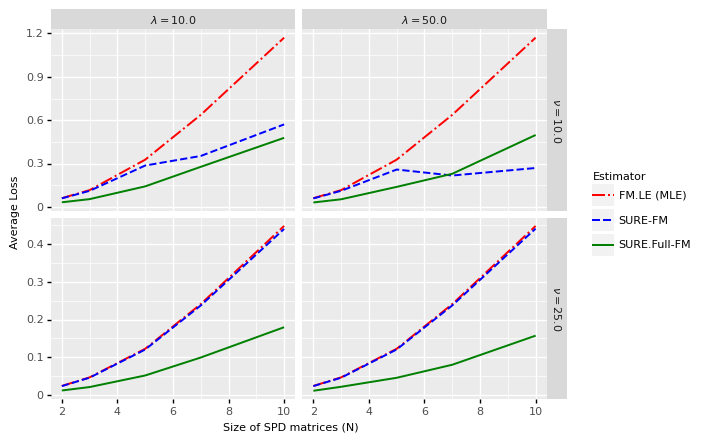

<ggplot: (8782277238983)>

In [50]:
f = open('exp_size.p', 'rb')
result = pickle.load(f)
risk_M = result['risk_M']

risk_M = pd.melt(risk_M, ['p','n','lambda', 'nu', 'N'], var_name='Estimator', value_name='risk')

def col_label(s):
    return '$\lambda = ' + str(s) + '$'

def row_label(s):
    return '$\\nu = ' + str(s) + '$'

#risk_M['risk'] = risk_M['risk']/risk_M['N']

p = (ggplot(risk_M)
    + aes(x='N', y='risk', color='Estimator', linetype='Estimator')
    + geom_line(size = 0.8)
    #+ geom_errorbar(aes(ymin = 'lower', ymax = 'upper'), width = 30)
    + facet_grid(['nu', 'lambda'], scales = 'free', labeller = labeller(rows = row_label, cols=col_label))
    + xlab('Size of SPD matrices (N)')
    + ylab('Average Loss')
    + scale_color_manual(labels = ['FM.LE (MLE)', 'SURE-FM', 'SURE.Full-FM'], 
                       values = ['red', 'blue', 'green'])
    + scale_linetype_manual(labels = ['FM.LE (MLE)', 'SURE-FM', 'SURE.Full-FM'], 
                          values = ['dashdot','dashed','solid'])
    + theme(axis_title=element_text(size=8), 
          axis_text=element_text(size=8),
          legend_title=element_text(size=8),
          legend_text=element_text(size=8),
          strip_text=element_text(size=8))
    #+ ggtitle(r'$\mu=diag(2,0.5,0.5)$, $\Psi = I_6$, $\lambda = 10$, $\nu=15$')
    )

#p.save('risk_M_size.pdf', dpi = 320, width = 6, height = 4, unit="in")
p

In [15]:
n = 50
lam = 10
nu = 30
p = 10
N = 5
ran_seed = 12345
m = 5 

q = int(N*(N+1)/2)
mu = np.eye(N)
Psi = np.eye(q)

I = np.eye(N)
Iq = np.eye(q)

np.random.seed(ran_seed)
Sigma = invwishart.rvs(nu, Psi, size = p)
M = np.zeros((p, N, N))
M = np.array([SPD_normal(1, mu, Sigma[i]/lam) for i in range(p)])
X = np.array([SPD_normal(n, M[i], Sigma[i]) for i in range(p)])

M_logE = np.array([FM_logE(X[i]) for i in range(p)])


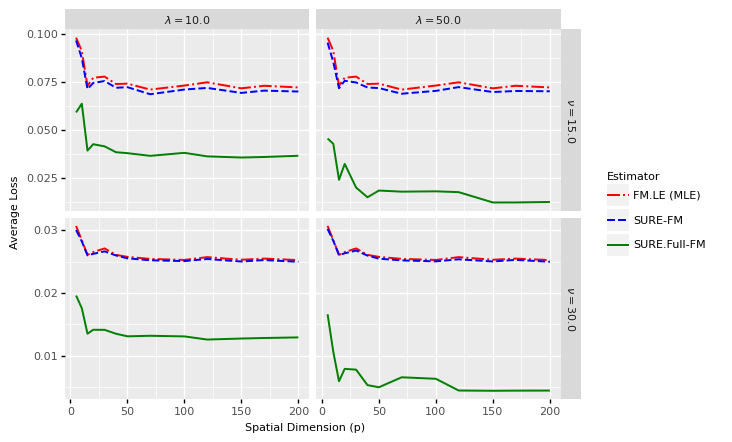

<ggplot: (8782265702428)>

In [12]:
# plots for synth exp 1-1 (Fig. 1)

f = open('exp_full_lognormal.p', 'rb')
result = pickle.load(f)
risk_M = result['risk_M']
risk_M_sd = result['risk_M_sd']
risk_M = pd.melt(risk_M, ['p','n','lambda', 'nu'], var_name='Estimator', value_name='risk')
risk_Sig = result['risk_Sig']
risk_Sig = pd.melt(risk_Sig, ['p','n','lambda', 'nu'], var_name='Estimator', value_name='risk')


risk_M_sd = pd.melt(risk_M_sd, ['p','n','lambda', 'nu'], var_name='Estimator', value_name='sd')
risk_M['sd'] = risk_M_sd['sd']
risk_M['lower'] = risk_M['risk'] - risk_M['sd']
risk_M['upper'] = risk_M['risk'] + risk_M['sd']


def col_label(s):
    return '$\lambda = ' + str(s) + '$'

def row_label(s):
    return '$\\nu = ' + str(s) + '$'

risk_M = risk_M[risk_M['Estimator'] != 'FM_GL']

p = (ggplot(risk_M)
    + aes(x='p', y='risk', color='Estimator', linetype='Estimator')
    + geom_line(size = 0.8)
    #+ geom_errorbar(aes(ymin = 'lower', ymax = 'upper'), width = 30)
    + facet_grid(['nu', 'lambda'], scales = 'free', labeller = labeller(rows = row_label, cols=col_label))
    + xlab('Spatial Dimension (p)')
    + ylab('Average Loss')
    + scale_color_manual(labels = ['FM.LE (MLE)', 'SURE-FM', 'SURE.Full-FM'], 
                       values = ['red', 'blue', 'green'])
    + scale_linetype_manual(labels = ['FM.LE (MLE)', 'SURE-FM', 'SURE.Full-FM'], 
                          values = ['dashdot','dashed','solid'])
    + theme(axis_title=element_text(size=8), 
          axis_text=element_text(size=8),
          legend_title=element_text(size=8),
          legend_text=element_text(size=8),
          strip_text=element_text(size=8))
    #+ ggtitle(r'$\mu=diag(2,0.5,0.5)$, $\Psi = I_6$, $\lambda = 10$, $\nu=15$')
    )
p
#p.save('risk_M.pdf', dpi = 320, width = 6, height = 4, unit="in")

[[2.  0.  0. ]
 [0.  0.5 0. ]
 [0.  0.  0.5]]
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[1.      0.5     0.25    0.125   0.0625  0.03125]
 [0.5     1.      0.5     0.25    0.125   0.0625 ]
 [0.25    0.5     1.      0.5     0.25    0.125  ]
 [0.125   0.25    0.5     1.      0.5     0.25   ]
 [0.0625  0.125   0.25    0.5     1.      0.5    ]
 [0.03125 0.0625  0.125   0.25    0.5     1.     ]]


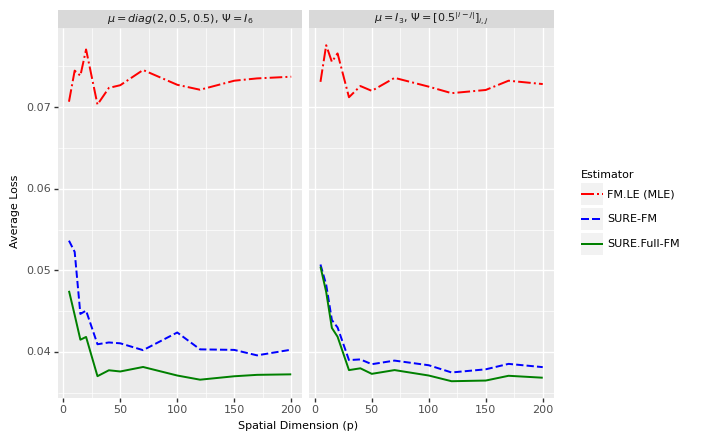

<ggplot: (8732326184430)>

In [12]:
# plots for synth exp 1-1 (Fig. 2)

f = open('exp_full_lognormal2.p', 'rb')
result = pickle.load(f)
risk_M = result['risk_M']
risk_M_sd = result['risk_M_sd']
risk_M = pd.melt(risk_M, ['p','n','lambda', 'nu'], var_name='Estimator', value_name='risk')
risk_M_sd = pd.melt(risk_M_sd, ['p','n','lambda', 'nu'], var_name='Estimator', value_name='sd')
risk_M['sd'] = risk_M_sd['sd']
risk_M['lower'] = risk_M['risk'] - risk_M['sd']
risk_M['upper'] = risk_M['risk'] + risk_M['sd']

risk_M_2 = risk_M.copy()
risk_M_2['scenario'] = 2

print(result['mu'])
print(result['Psi'])

f = open('exp_full_lognormal3.p', 'rb')
result = pickle.load(f)
risk_M = result['risk_M']
risk_M_sd = result['risk_M_sd']
risk_M = pd.melt(risk_M, ['p','n','lambda', 'nu'], var_name='Estimator', value_name='risk')
risk_M_sd = pd.melt(risk_M_sd, ['p','n','lambda', 'nu'], var_name='Estimator', value_name='sd')
risk_M['sd'] = risk_M_sd['sd']
risk_M['lower'] = risk_M['risk'] - risk_M['sd']
risk_M['upper'] = risk_M['risk'] + risk_M['sd']

risk_M_3 = risk_M.copy()
risk_M_3['scenario'] = 3

print(result['mu'])
print(result['Psi'])

risk_M = pd.concat([risk_M_2, risk_M_3])

#print(risk_M)

def col_label(s):
    return {'2': r'$\mu=diag(2,0.5,0.5)$, $\Psi = I_6$', '3': r'$\mu = I_3$, $\Psi = [0.5^{|i-j|}]_{i,j}$'}[s]

risk_M = risk_M[risk_M['Estimator'] != 'FM_GL']
p = (ggplot(risk_M)
    + aes(x='p', y='risk', color='Estimator', linetype='Estimator')
    + geom_line(size = 0.8)
    #+ geom_errorbar(aes(ymin = 'lower', ymax = 'upper'), width = 30)
    + facet_grid('.~scenario', scales = 'free', labeller = labeller(cols = col_label))
    + xlab('Spatial Dimension (p)')
    + ylab('Average Loss')
    + scale_color_manual(labels = ['FM.LE (MLE)', 'SURE-FM', 'SURE.Full-FM'], 
                       values = ['red', 'blue', 'green'])
    + scale_linetype_manual(labels = ['FM.LE (MLE)', 'SURE-FM', 'SURE.Full-FM'], 
                          values = ['dashdot','dashed','solid'])
    + theme(axis_title=element_text(size=8), 
          axis_text=element_text(size=8),
          legend_title=element_text(size=8),
          legend_text=element_text(size=8),
          strip_text=element_text(size=8))
    )
p

p.save('risk_M2.pdf', dpi = 320, width = 6, height = 2, unit="in")

In [9]:
risk = risk_M.copy()
risk.loc[:,'risk':] = risk.loc[:,'risk':] + risk_Sig.loc[:,'risk':]
risk

,p,n,lambda,nu,Estimator,risk,sd,lower,upper
0,5.0,10.0,10.0,15.0,FM_LogE,0.218700,NaN,NaN,NaN
1,5.0,10.0,50.0,15.0,FM_LogE,0.218700,NaN,NaN,NaN
2,5.0,10.0,10.0,30.0,FM_LogE,0.041311,NaN,NaN,NaN
3,5.0,10.0,50.0,30.0,FM_LogE,0.041311,NaN,NaN,NaN
4,10.0,10.0,10.0,15.0,FM_LogE,0.197179,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
203,170.0,10.0,50.0,30.0,SURE_full,0.013462,NaN,NaN,NaN
204,200.0,10.0,10.0,15.0,SURE_full,0.110573,NaN,NaN,NaN
205,200.0,10.0,50.0,15.0,SURE_full,0.086569,NaN,NaN,NaN
206,200.0,10.0,10.0,30.0,SURE_full,0.021909,NaN,NaN,NaN


In [10]:
p = (ggplot(risk)
    + aes(x='p', y='risk', color='Estimator', linetype='Estimator')
    + geom_line(size = 0.8)
    #+ geom_errorbar(aes(ymin = 'lower', ymax = 'upper'), width = 30)
    + facet_grid(['nu', 'lambda'], scales = 'free', labeller = labeller(rows = row_label, cols=col_label))
    + xlab('Dimension (p)')
    + ylab('Average Loss')
    + scale_color_manual(labels = ['FM.GL', 'FM.LE (MLE)', 'SURE-FM', 'SURE.Full-FM'], 
                       values = ['darkgreen', 'red', 'blue', 'green'])
    + scale_linetype_manual(labels = ['FM.GL', 'FM.LE (MLE)', 'SURE-FM', 'SURE.Full-FM'], 
                          values = ['dotted','dashdot','dashed','solid'])
    + theme(axis_title=element_text(size=8), 
          axis_text=element_text(size=8),
          legend_title=element_text(size=8),
          legend_text=element_text(size=8),
          strip_text=element_text(size=8))
    )
p

ValueError: All arrays must be of the same length